# Imports

In [7]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


## Labelling using AutoModel

In [4]:
# Ensure GPU is available and set as device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer_bias = AutoTokenizer.from_pretrained("d4data/bias-detection-model", from_tf=True)
model_bias = AutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model", from_tf=True).to(device)

# Load and preprocess your data
df_cleaned = pd.read_csv('cleaned_csv.csv')
df_cleaned.drop_duplicates(subset=["Content"], inplace=True)

def predict_bias_probabilities(texts, tokenizer, model):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1)[0]  # Get class probabilities
    return [round(float(prob), 3) for prob in probabilities]  # Round to three decimal places

df_cleaned['Bias_Probabilities'] = df_cleaned['Content'].apply(lambda x: predict_bias_probabilities([x], tokenizer_bias, model_bias))

df_cleaned.to_csv('classified_with_probabilities.csv', index=False)


Using device: cuda


All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


## Bias Levels

In [7]:
df_classified = pd.read_csv('classified_with_probabilities.csv')
# Function to extract the second value from a string like "[0.388, 0.612]"
def extract_second_value(prob_string):
    prob_list = eval(prob_string) 
    return prob_list[1] if len(prob_list) >= 2 else None

# Apply the function to the 'Bias_Probabilities' column and store the result as 'Bias_Label'
df_classified['Bias_Label'] = df_classified['Bias_Probabilities'].apply(extract_second_value)
df_classified.drop(columns=['Bias_Probabilities'], inplace=True)
df_classified.to_csv("classified_labeled.csv", index=False)


In [18]:
df_labelled = pd.read_csv('classified_labeled.csv')
df_labelled.head()

,Title,Content,Length,OutletName,TopicName,Author_Name,Bias_Label
0,Broos and Bafana could land themselves in Afco...,Morocco reached 2022 World Cup semifinals amon...,2978,NEWS24,sport,NEWS24 - No Explicit Author - sportNEWS24 - No...,0.612
1,Strickland stuns champion Adesanya to win UFC ...,Sean Strickland defeated Israel Adesanya gruel...,4499,NEWS24,sport,NEWS24 - No Explicit Author - sportNEWS24 - No...,0.934
2,FIA makes last-minute change to Qatar GP weeke...,Following Fridays running 2023 Qatar Grand Pri...,1071,NEWS24,sport,Charlen RaymondCharlen Raymond,0.501
3,Jones not interested in vital Australia perfor...,Wallabies coach Eddie Jones says Rugby Austral...,2095,NEWS24,sport,NEWS24 - No Explicit Author - sportNEWS24 - No...,0.985
4,"Williams sisters paved way, says Gauff after U...",Coco Gauff attributed US Open triumph tennis i...,3066,NEWS24,sport,NEWS24 - No Explicit Author - sportNEWS24 - No...,0.945


# Labelling dataset

In [19]:
thresholds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
class_labels = ['least_biased', 'slightly_biased', 'somewhat_biased', 'biased', 'very_biased', 'most_biased']

def assign_class(probability, thresholds, class_labels):
    for i, threshold in enumerate(thresholds):
        if probability <= threshold:
            return class_labels[i]
    return class_labels[-1]

# Assign classes
df_labelled['Bias_Class'] = df_labelled['Bias_Label'].apply(lambda x: assign_class(x, thresholds, class_labels))

class_to_idx = {cls: idx for idx, cls in enumerate(class_labels)}
df_labelled['Bias_Class'] = df_labelled['Bias_Class'].map(class_to_idx)
df_labelled.head()


,Title,Content,Length,OutletName,TopicName,Author_Name,Bias_Label,Bias_Class
0,Broos and Bafana could land themselves in Afco...,Morocco reached 2022 World Cup semifinals amon...,2978,NEWS24,sport,NEWS24 - No Explicit Author - sportNEWS24 - No...,0.612,4
1,Strickland stuns champion Adesanya to win UFC ...,Sean Strickland defeated Israel Adesanya gruel...,4499,NEWS24,sport,NEWS24 - No Explicit Author - sportNEWS24 - No...,0.934,5
2,FIA makes last-minute change to Qatar GP weeke...,Following Fridays running 2023 Qatar Grand Pri...,1071,NEWS24,sport,Charlen RaymondCharlen Raymond,0.501,3
3,Jones not interested in vital Australia perfor...,Wallabies coach Eddie Jones says Rugby Austral...,2095,NEWS24,sport,NEWS24 - No Explicit Author - sportNEWS24 - No...,0.985,5
4,"Williams sisters paved way, says Gauff after U...",Coco Gauff attributed US Open triumph tennis i...,3066,NEWS24,sport,NEWS24 - No Explicit Author - sportNEWS24 - No...,0.945,5


# Splitting and training Model on own data

In [23]:
train_df, test_df = train_test_split(df_labelled, test_size=0.2, random_state=42)

tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer_roberta(train_df["Content"].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=512)
test_encodings = tokenizer_roberta(test_df["Content"].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=512)

# Convert labels to tensors
train_labels = torch.tensor(train_df["Bias_Class"].values)
test_labels = torch.tensor(test_df["Bias_Class"].values)

# Create datasets and data loaders
train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels)
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], test_labels)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [24]:
num_labels = len(class_labels)
model_roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels).to(device)

# Training setup
optimizer = AdamW(model_roberta.parameters(), lr=1e-5)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model_roberta.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model_roberta(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

model_roberta.save_pretrained("/final_labelled_model_classifier")  # Replace with your actual path


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should pr

In [5]:
import pandas as pd

In [8]:
cleaned_df = pd.read_csv('cleaned_csv.csv')
train_df_, test_df_ = train_test_split(cleaned_df, test_size=0.2, random_state=42)

# Predictions using my retrained RoBERTa classifier

In [10]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Initialize the RoBERTa tokenizer
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the test data
test_encodings = tokenizer_roberta(test_df_["Content"].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=512)
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"])
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load the trained model
model_path = 'final_labelled_model_classifier'
model_roberta = RobertaForSequenceClassification.from_pretrained(model_path)
model_roberta.eval()  # Set the model to evaluation mode

# Predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)
predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = [b.to(device) for b in batch]
        outputs = model_roberta(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).cpu().numpy())

# Save predictions
test_df_['Predictions'] = predictions
test_df_.to_csv('test_predictions.csv', index=False)


# Investigation of predictions

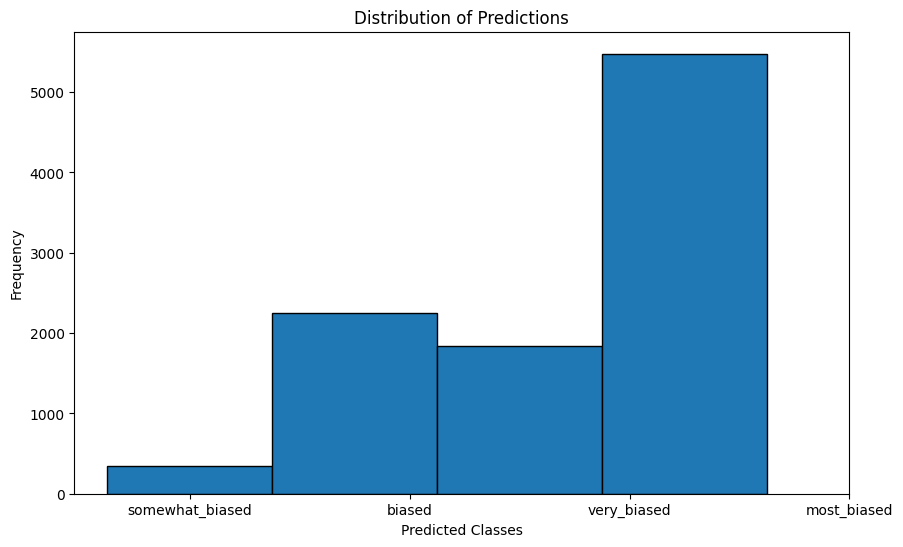

In [14]:
import matplotlib.pyplot as plt

# Assuming predictions is a list of your model's predicted class indices

# Plot distribution of predictions
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=len(set(predictions)), edgecolor='k', align='left')
plt.xlabel('Predicted Classes')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions')

# Dynamically set x-ticks based on unique predicted classes
unique_predictions = sorted(set(predictions))
labels = ['least_biased', 'slightly_biased', 'somewhat_biased', 'biased', 'very_biased', 'most_biased']
xtick_labels = [labels[i] for i in unique_predictions]

plt.xticks(ticks=unique_predictions, labels=xtick_labels)
plt.show()


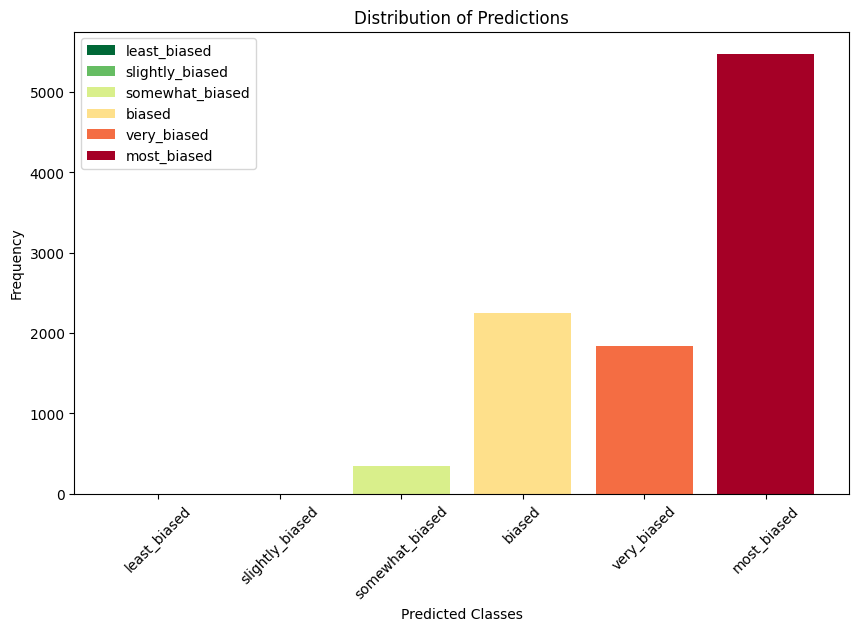

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_pred = pd.read_csv('test_predictions.csv')
predictions = df_pred['Predictions']

# Define the list of all possible labels
all_labels = ['Factual', 'Somewhat Factual', 'Indifferent', 'Biased', 'Very Biased', 'Extremely Biased']

# Create a dictionary to store label counts
label_counts = {label: predictions.count(index) for index, label in enumerate(all_labels)}

# Define custom colors for each label with a gradual transition from red to green
n_labels = len(all_labels)
colors = plt.cm.RdYlGn(np.linspace(1, 0, n_labels))  # Reverse the color map

# Plot distribution of predictions
plt.figure(figsize=(10, 6))

for i, label in enumerate(all_labels):
    count = label_counts[label]
    plt.bar(label, count, color=colors[i], label=label)

plt.xlabel('Predicted Classes')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions')
plt.legend()

# Dynamically set x-ticks based on all possible labels
plt.xticks(rotation=45)
plt.show()


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('test_predictions.csv')

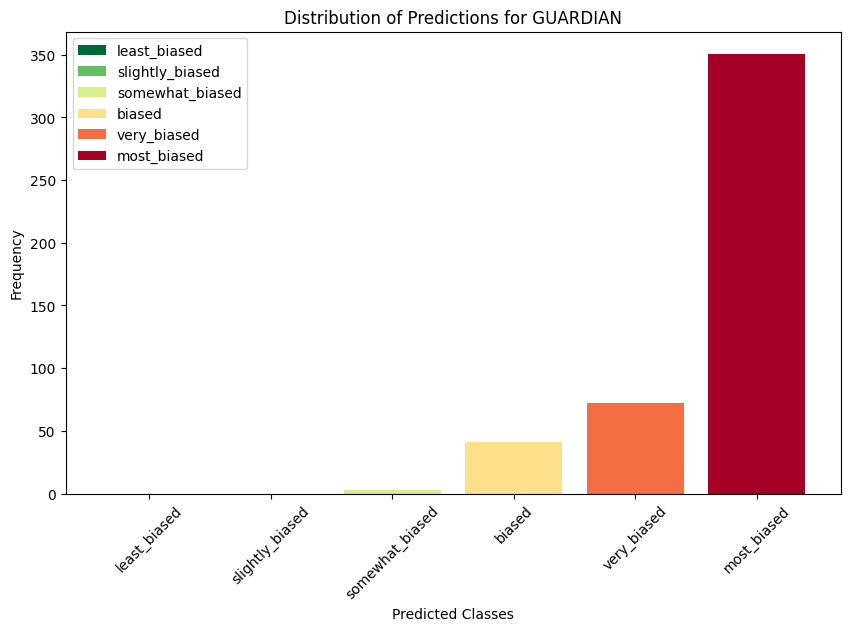

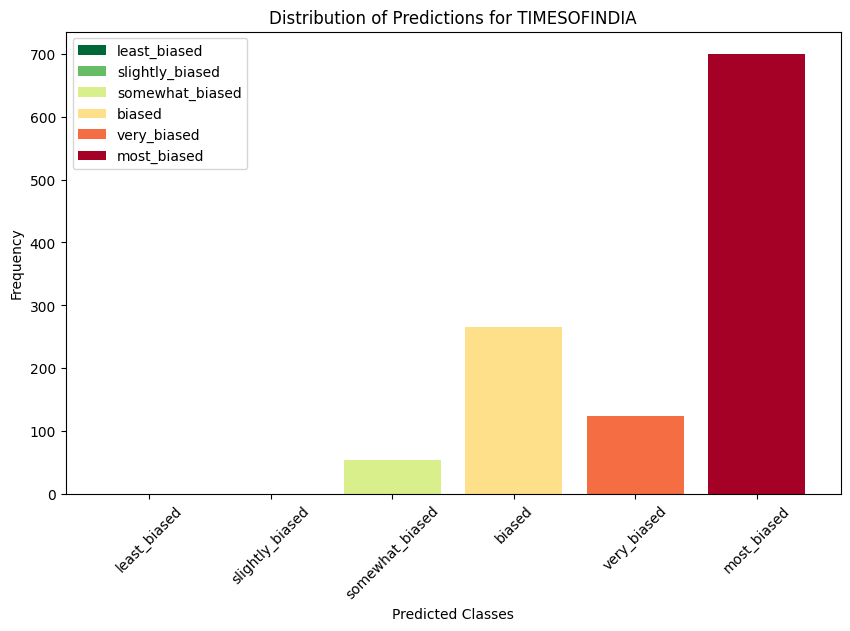

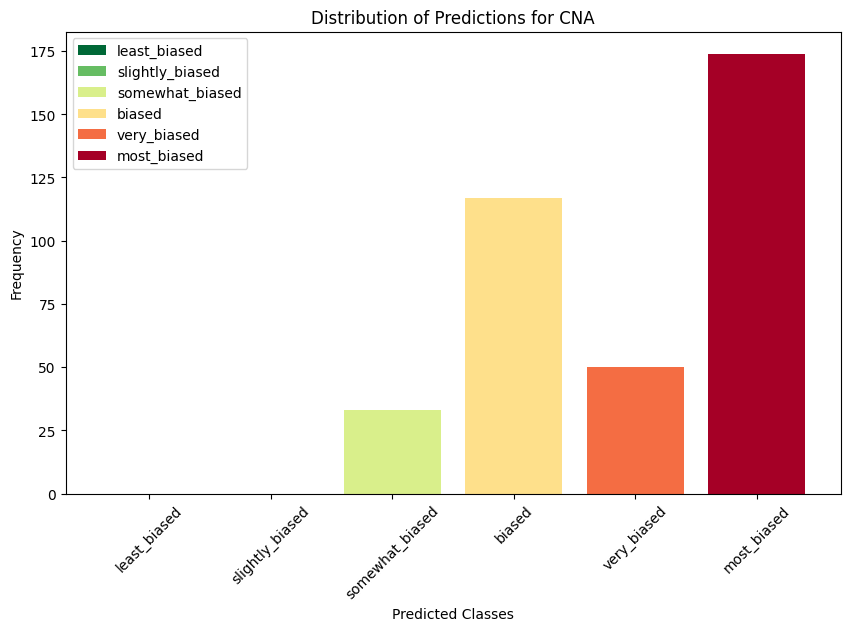

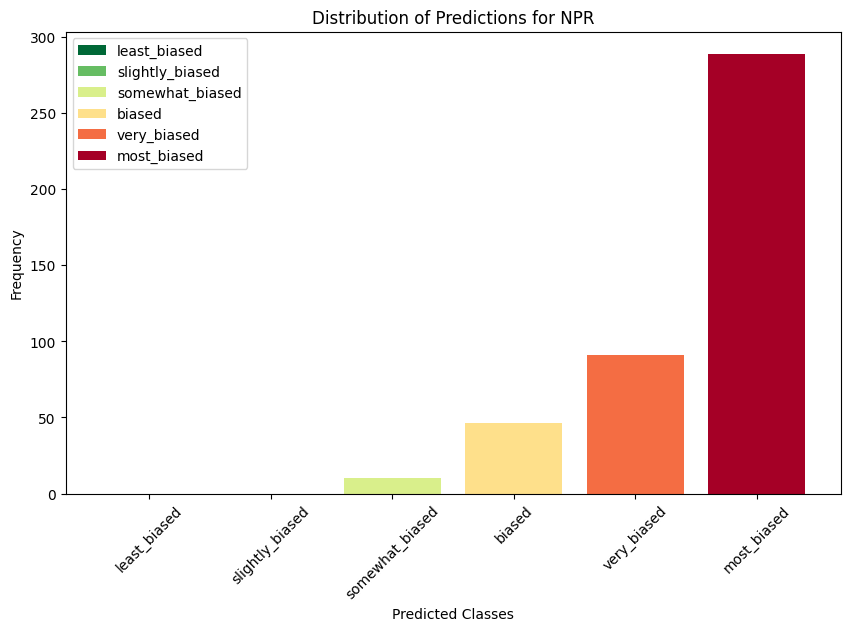

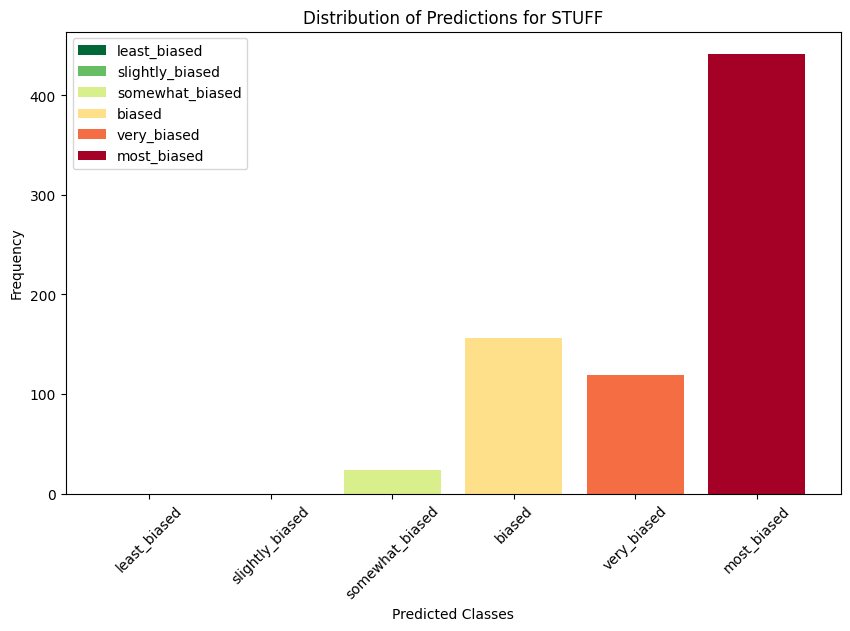

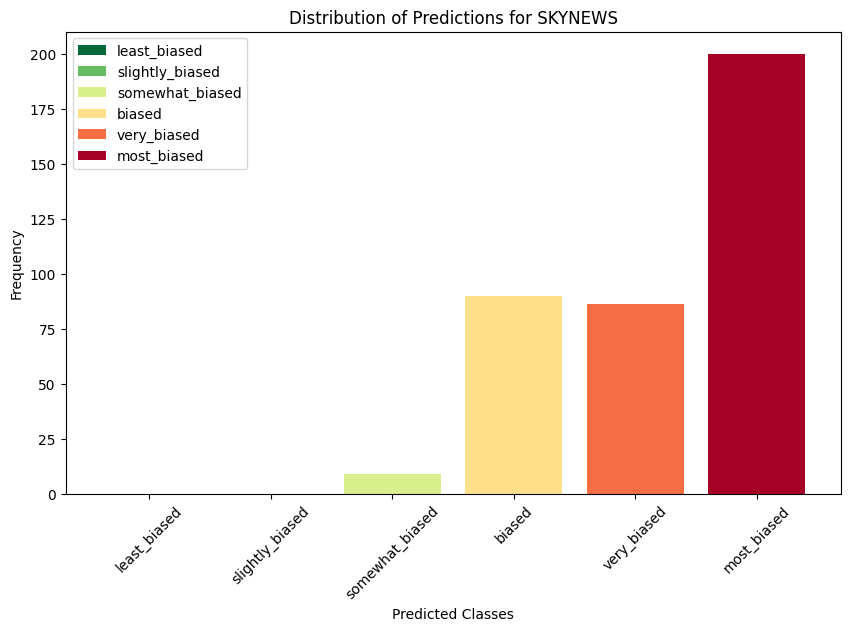

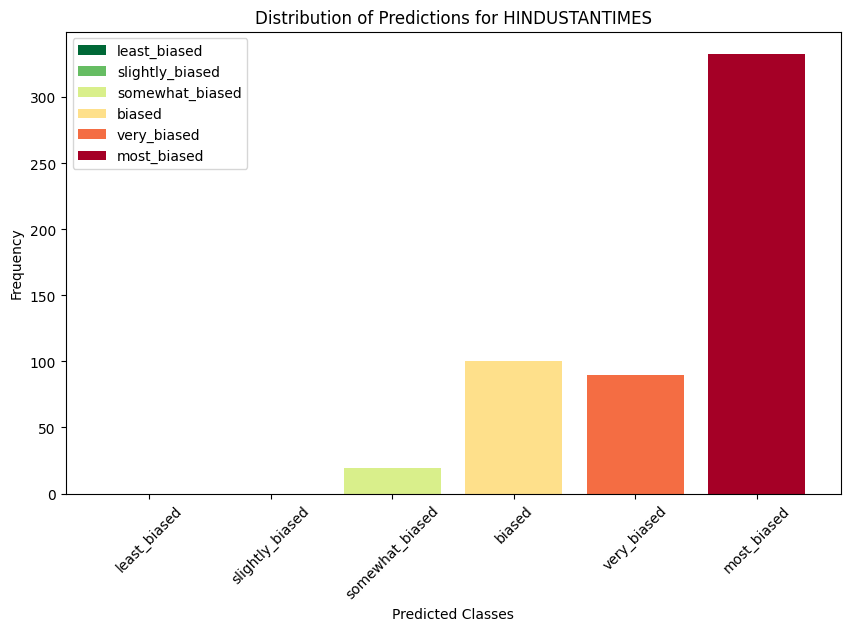

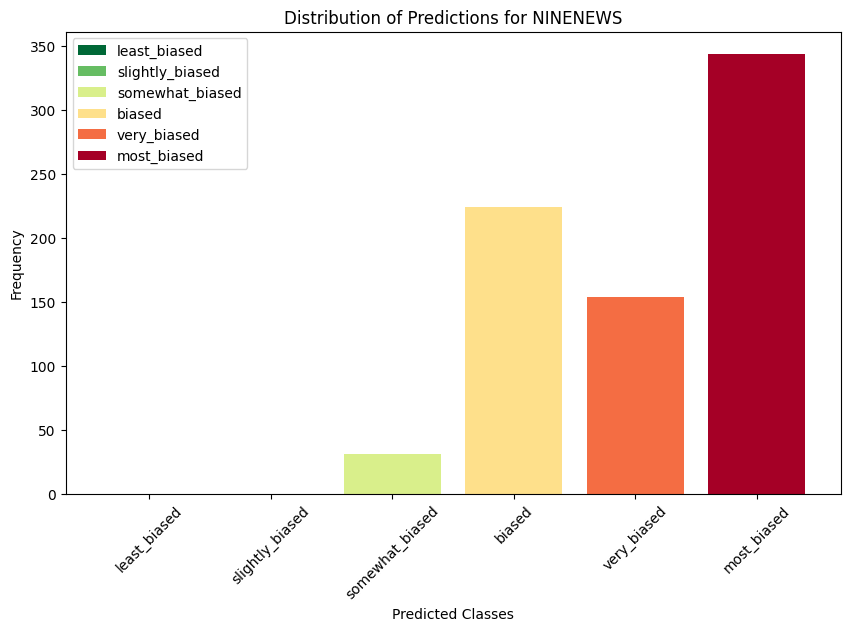

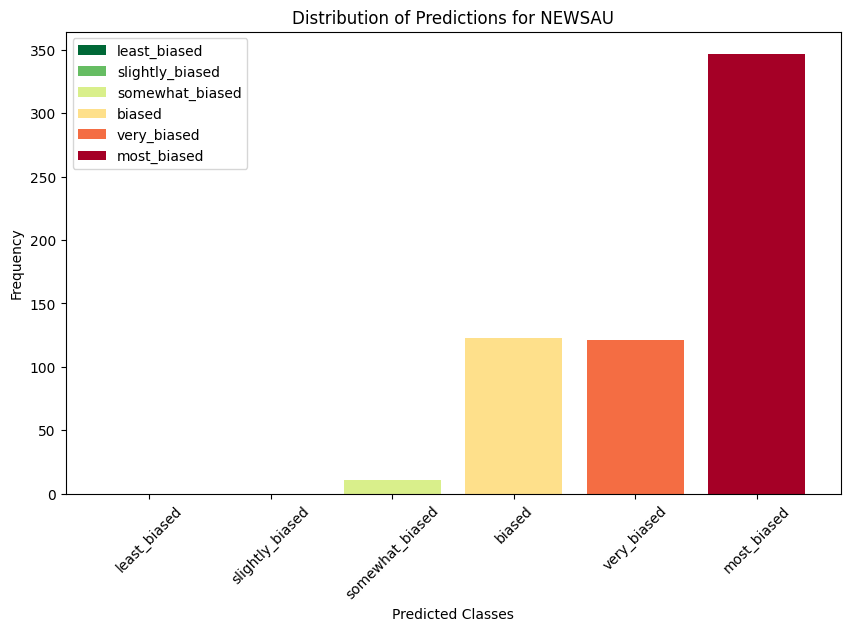

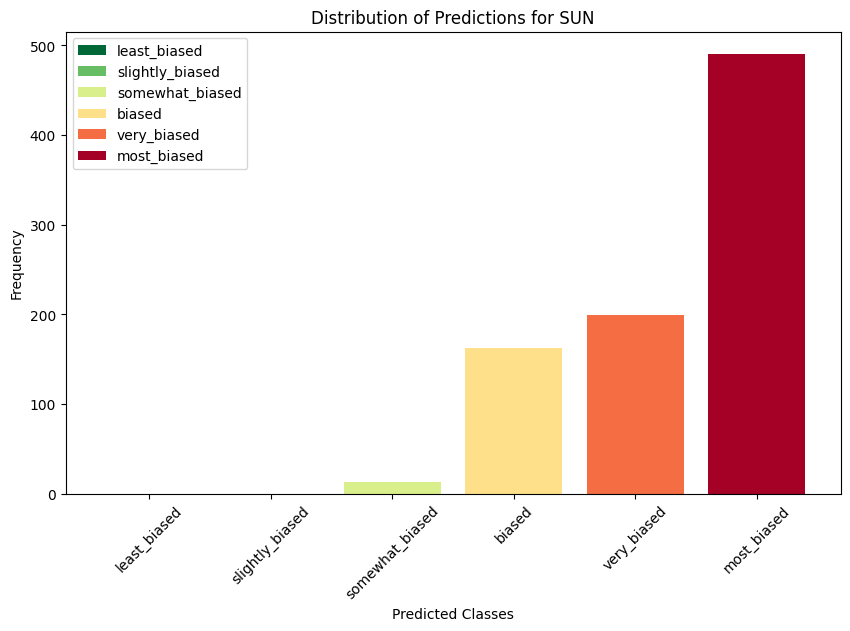

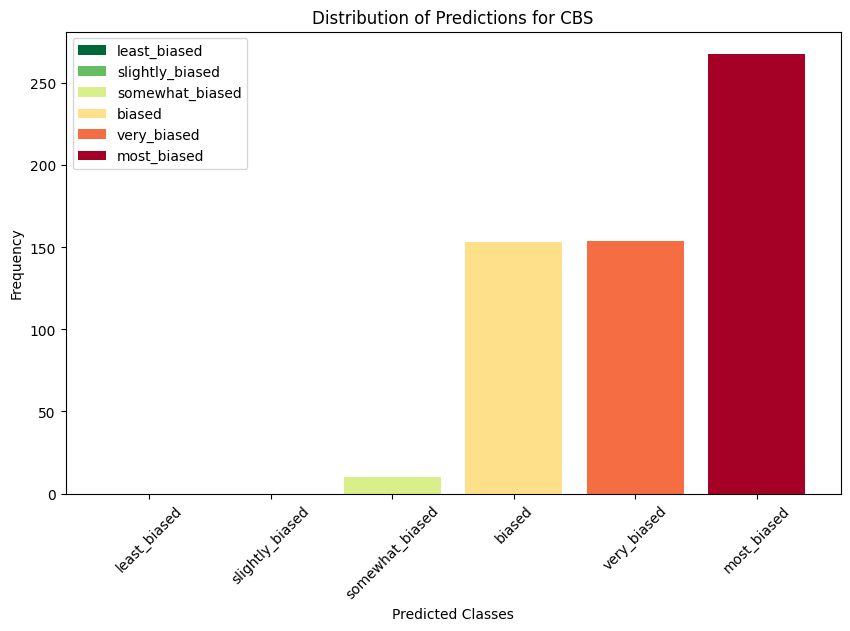

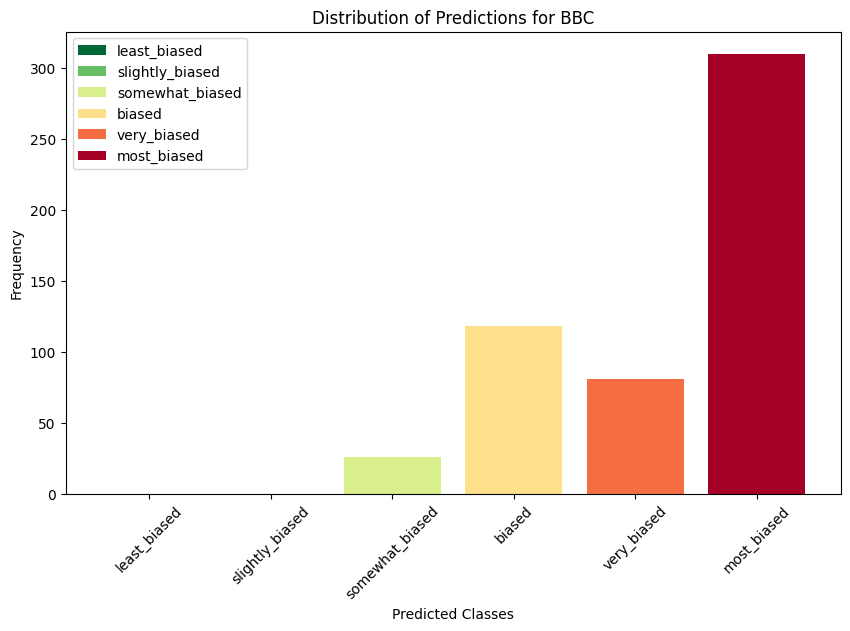

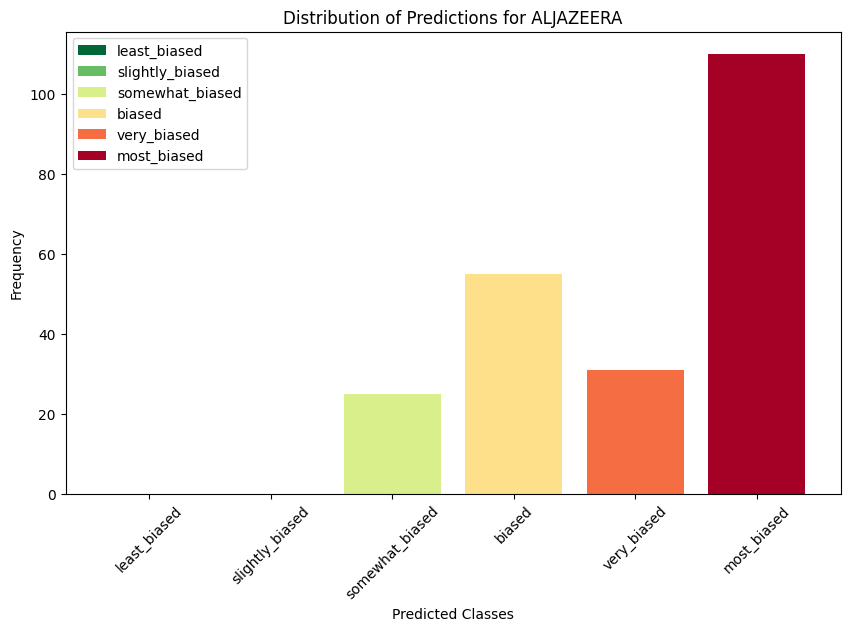

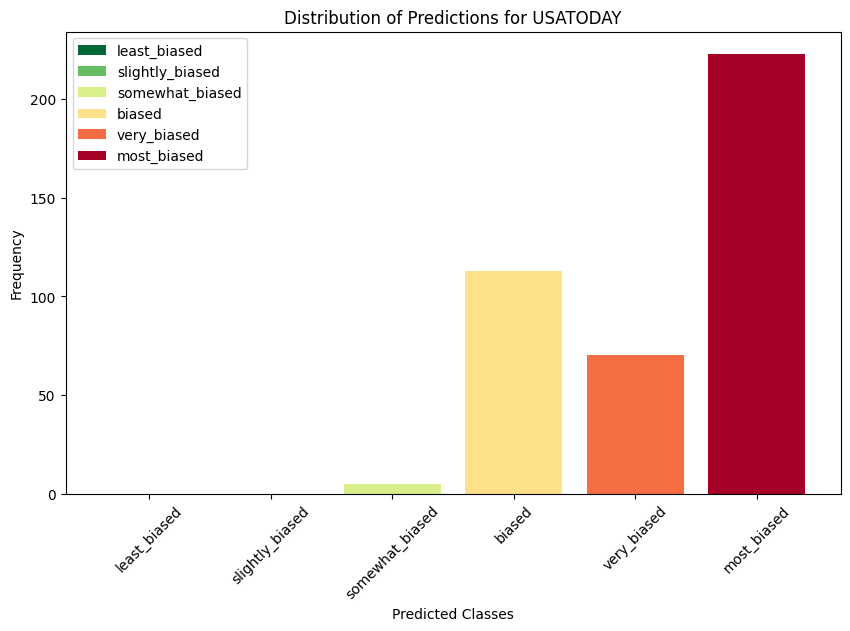

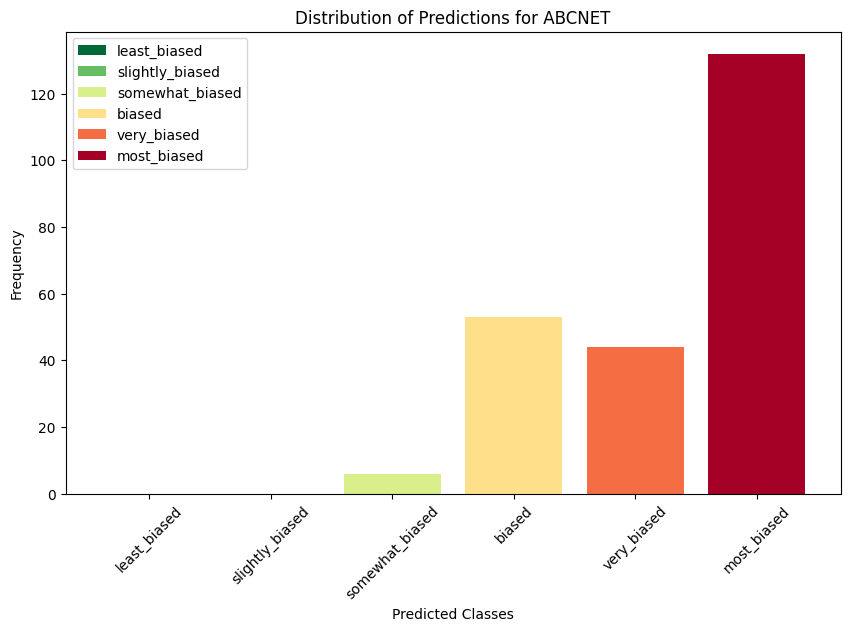

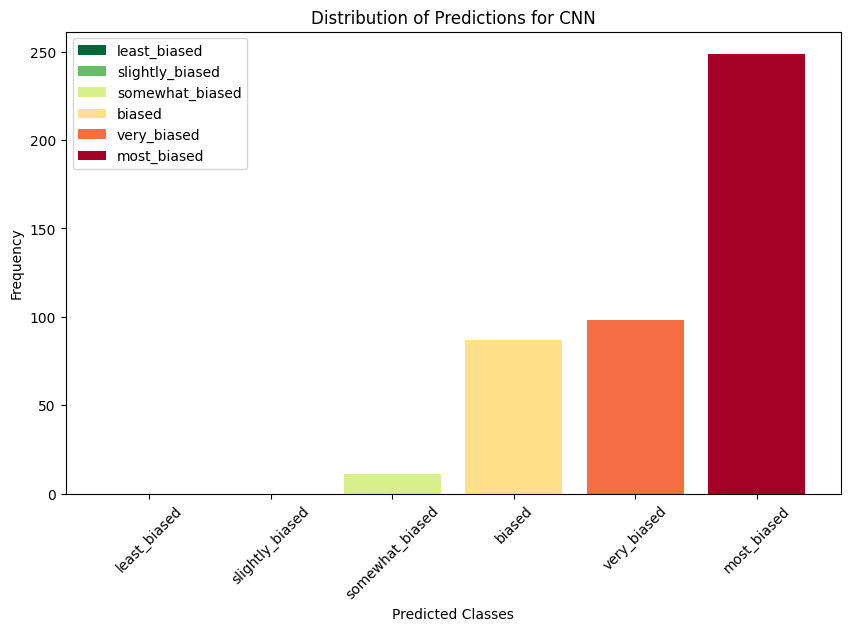

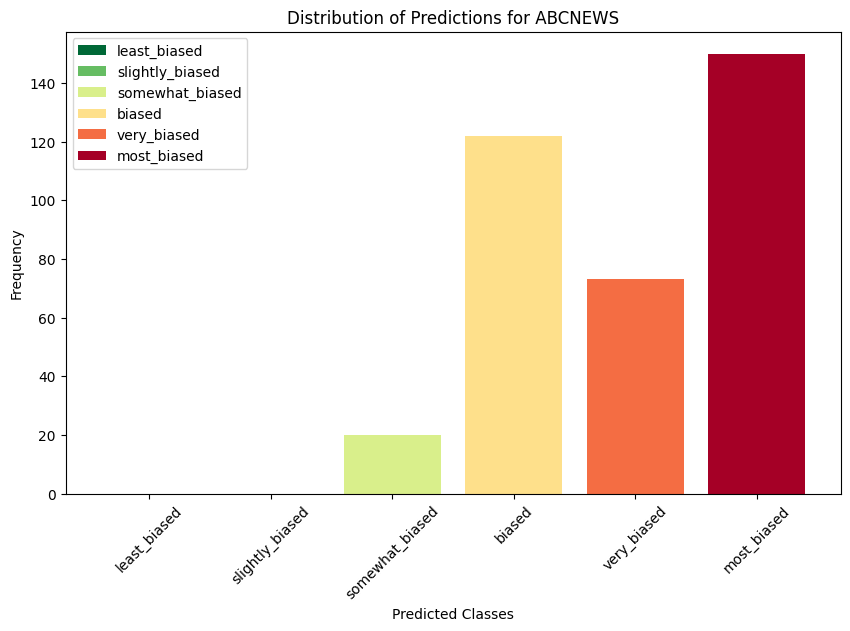

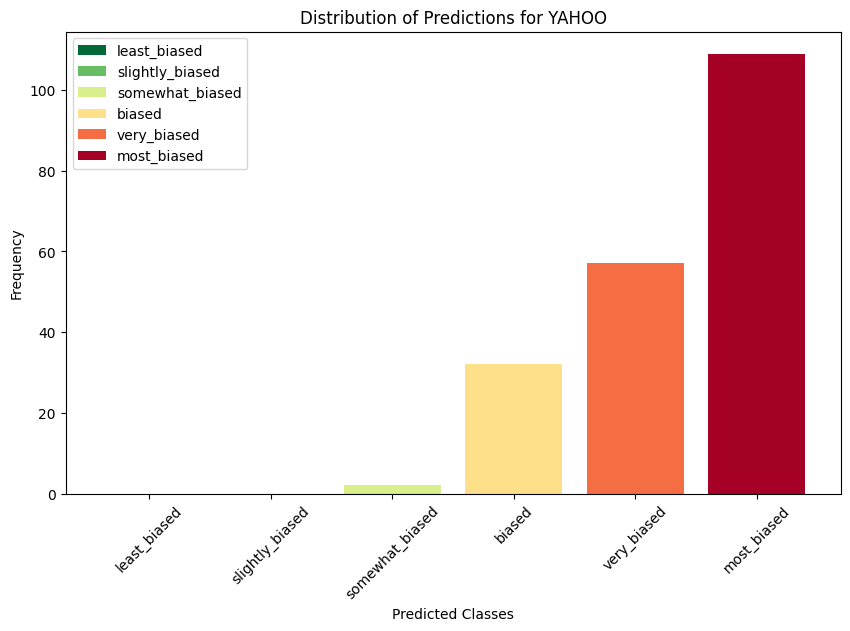

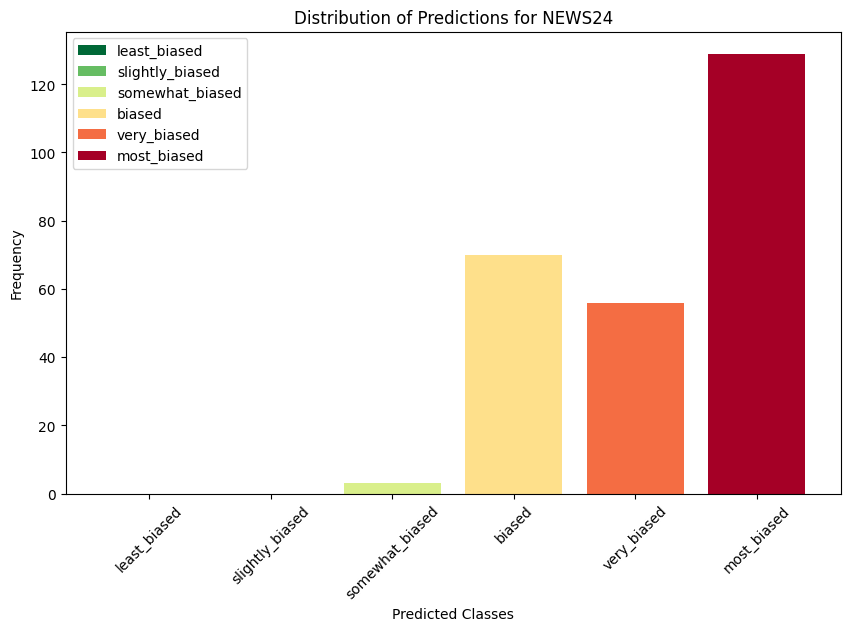

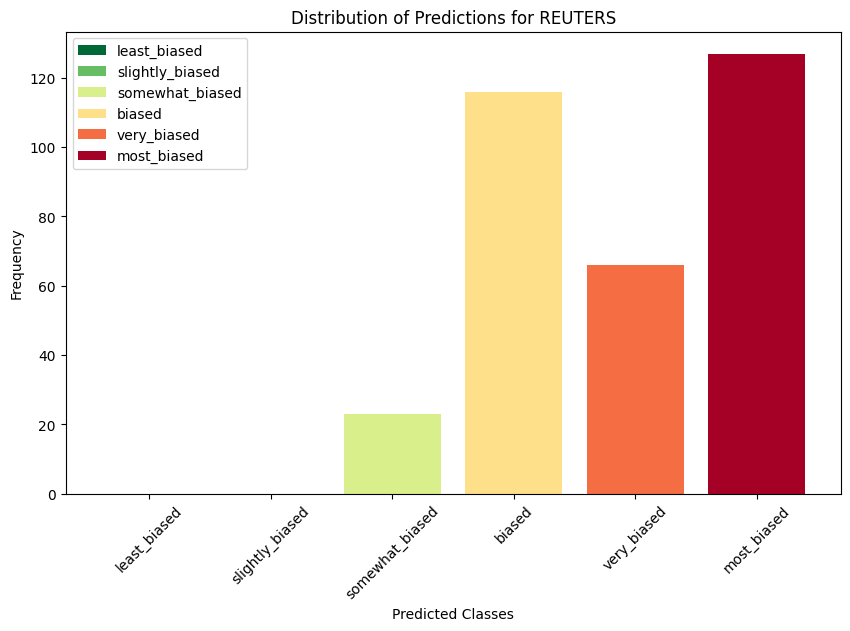

In [24]:
# Define the list of all possible labels
all_labels = ['least_biased', 'slightly_biased', 'somewhat_biased', 'biased', 'very_biased', 'most_biased']

# Define custom colors for each label with a gradual transition from red to green
n_labels = len(all_labels)
colors = plt.cm.RdYlGn(np.linspace(1, 0, n_labels))  # Reverse the color map

# Get unique OutletNames
unique_outlets = df['OutletName'].unique()

# Create a separate graph for each OutletName
for outlet in unique_outlets:
    outlet_df = df[df['OutletName'] == outlet]

    # Calculate label counts for the current OutletName
    label_counts = {label: outlet_df['Predictions'].tolist().count(index) for index, label in enumerate(all_labels)}

    # Plot distribution of predictions for the current OutletName
    plt.figure(figsize=(10, 6))

    for i, label in enumerate(all_labels):
        count = label_counts[label]
        plt.bar(label, count, color=colors[i], label=label)

    plt.xlabel('Predicted Classes')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Predictions for {outlet}')
    plt.legend()

    # Dynamically set x-ticks based on all possible labels
    plt.xticks(rotation=45)

    # Show or save the individual graph for each OutletName
    plt.show()  # You can also save the graphs if needed


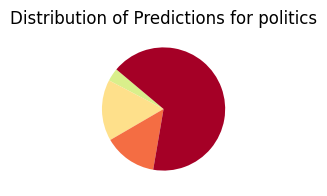

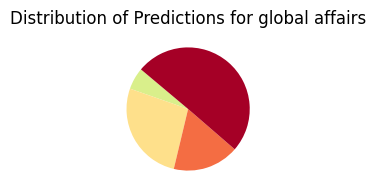

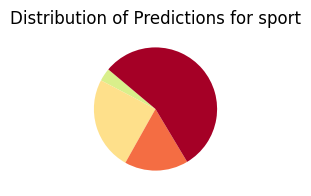

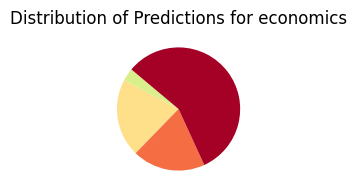

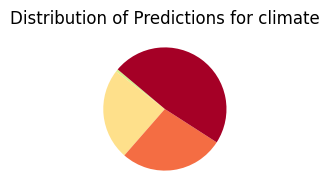

In [10]:
all_labels = ['Factual', 'Somewhat Factual', 'Indifferent', 'Biased', 'Very Biased', 'Extremely Biased']

n_labels = len(all_labels)
colors = plt.cm.RdYlGn(np.linspace(1, 0, n_labels))  # Reverse the color map

unique_topics = df_pred['TopicName'].unique()

for topic in unique_topics:
    topic_df = df_pred[df_pred['TopicName'] == topic]

    label_counts = [topic_df['Predictions'].tolist().count(index) for index in range(len(all_labels))]

    plt.figure(figsize=(2, 2))
    plt.pie(label_counts, colors=colors, startangle=140)
    plt.title(f'Distribution of Predictions for {topic}')

    plt.show()


### Bias Levels of Authors

In [30]:
author_bias_avg = df.groupby('Author_Name')['Predictions'].mean()

highest_avg_authors = author_bias_avg.max()

lowest_avg_authors = author_bias_avg[author_bias_avg == highest_avg_authors]


print("Authors with the lowest average bias label:")
for author in lowest_avg_authors.index:
    outlet_name = df[df['Author_Name'] == author]['OutletName'].iloc[0]  # Get the OutletName for the author
    print(f"Author: {author}, OutletName: {outlet_name}, Average Bias Label: {highest_avg_authors}")


Authors with the lowest average bias label:
Author:  Adam Easton Adam Easton, OutletName: BBC, Average Bias Label: 5.0
Author:  Aleem Maqbool & Harry Farley Aleem Maqbool & Harry Farley, OutletName: BBC, Average Bias Label: 5.0
Author:  Angus Cochrane Angus Cochrane, OutletName: BBC, Average Bias Label: 5.0
Author:  Anna Foster Anna Foster, OutletName: BBC, Average Bias Label: 5.0
Author:  Annabelle Liang & Joe Tidy Annabelle Liang & Joe Tidy, OutletName: BBC, Average Bias Label: 5.0
Author:  Antoinette Radford & Graeme Baker Antoinette Radford & Graeme Baker, OutletName: BBC, Average Bias Label: 5.0
Author:  Bernd Debusmann Jr and Sam Cabral Bernd Debusmann Jr and Sam Cabral, OutletName: BBC, Average Bias Label: 5.0
Author:  Chris Mason Chris Mason, OutletName: BBC, Average Bias Label: 5.0
Author:  DJ Edu DJ Edu, OutletName: BBC, Average Bias Label: 5.0
Author:  Damien McGuinness Damien McGuinness, OutletName: BBC, Average Bias Label: 5.0
Author:  Daniel Thomas Daniel Thomas, OutletNa

In [31]:
author_bias_avg = df.groupby('Author_Name')['Predictions'].mean()

lowest_avg_bias = author_bias_avg.min()

lowest_avg_authors = author_bias_avg[author_bias_avg == lowest_avg_bias]

print("Authors with the lowest average bias label:")
for author in lowest_avg_authors.index:
    outlet_name = df[df['Author_Name'] == author]['OutletName'].iloc[0]  # Get the OutletName for the author
    print(f"Author: {author}, OutletName: {outlet_name}, Average Bias Label: {lowest_avg_bias}")


Authors with the lowest average bias label:
Author:  Hannah Ritchie & Derek Cai Hannah Ritchie & Derek Cai, OutletName: BBC, Average Bias Label: 2.0
Author: ADRIAN WOJNAROWSKIADRIAN WOJNAROWSKI, OutletName: ABCNEWS, Average Bias Label: 2.0
Author: Aisling BrennanAisling Brennan, OutletName: NEWSAU, Average Bias Label: 2.0
Author: Andrius SytasAndrius Sytas, OutletName: REUTERS, Average Bias Label: 2.0
Author: BRETT OKAMOTOBRETT OKAMOTO, OutletName: ABCNEWS, Average Bias Label: 2.0
Author: By Abel Alvarado, CNNBy Abel Alvarado, CNN, OutletName: CNN, Average Bias Label: 2.0
Author: By Akanksha Sharma and Heather Chen, CNNBy Akanksha Sharma and Heather Chen, CNN, OutletName: CNN, Average Bias Label: 2.0
Author: By Akanksha Sharma, Junko Ogura and Mayumi Maruyama, CNNBy Akanksha Sharma, Junko Ogura and Mayumi Maruyama, CNN, OutletName: CNN, Average Bias Label: 2.0
Author: By Caitlin Danaher, CNNBy Caitlin Danaher, CNN, OutletName: CNN, Average Bias Label: 2.0
Author: By Chris Lau, Jennifer

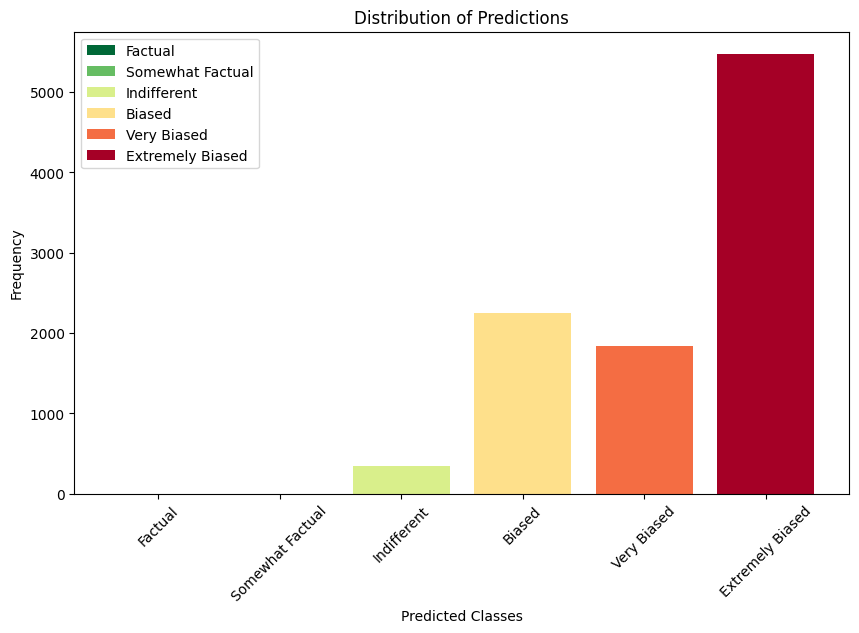

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_pred = pd.read_csv('test_predictions.csv')
predictions = df_pred['Predictions'].tolist()

# Define the list of all possible labels
all_labels = ['Factual', 'Somewhat Factual', 'Indifferent', 'Biased', 'Very Biased', 'Extremely Biased']

# Create a dictionary to store label counts
label_counts = {label: predictions.count(index) for index, label in enumerate(all_labels)}

# Define custom colors for each label with a gradual transition from red to green
n_labels = len(all_labels)
colors = plt.cm.RdYlGn(np.linspace(1, 0, n_labels))  # Reverse the color map

# Plot distribution of predictions
plt.figure(figsize=(10, 6))

for i, label in enumerate(all_labels):
    count = label_counts[label]
    plt.bar(label, count, color=colors[i], label=label)

plt.xlabel('Predicted Classes')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions')
plt.legend()

# Dynamically set x-ticks based on all possible labels
plt.xticks(rotation=45)
plt.show()
